In [1]:
%load_ext autoreload
%autoreload 2

from pathlib import Path

import numpy  as np
import pandas as pd
import h5py

from tqdm import tqdm
from astropy import units as u
from scipy.interpolate import interp1d

import ehtplot
from matplotlib import pyplot as plt, cm

from common import dalt
from common import hallmark as hm
from common import viz
from common import io_ipole as io

In [2]:
pf_img = hm.ParaFrame('model/Illinois_thermal/{freq}/{mag}a{aspin:g}_w5/img_s{snapshot:d}_Rh{Rhigh:d}_i{inc:d}.h5')

for k in set(pf_img.keys()) - {'path'}:
    globals()[k] = np.unique(pf_img[k])
    print(k, globals()[k][:16])

Failed to parse "model/Illinois_thermal/86GHz-largefov/Ma+0.5_w5/img_s05008_Rh40_i150_BADINPUT.h5"
Failed to parse "model/Illinois_thermal/86GHz-largefov/Ma+0.5_w5/img_s05015_Rh10_i170_BADINPUT.h5"
Failed to parse "model/Illinois_thermal/86GHz-largefov/Ma+0.5_w5/img_s05024_Rh160_i150_BADINPUT.h5"
Failed to parse "model/Illinois_thermal/86GHz-largefov/Ma+0.5_w5/img_s05043_Rh160_i30_BADINPUT.h5"
Failed to parse "model/Illinois_thermal/86GHz-largefov/Ma+0.5_w5/img_s05044_Rh40_i90_BADINPUT.h5"
Failed to parse "model/Illinois_thermal/86GHz-largefov/Ma+0.5_w5/img_s05045_Rh10_i10_BADINPUT.h5"
Failed to parse "model/Illinois_thermal/86GHz-largefov/Ma+0.5_w5/img_s05046_Rh40_i30_BADINPUT.h5"
Failed to parse "model/Illinois_thermal/86GHz-largefov/Ma+0.5_w5/img_s05069_Rh160_i170_BADINPUT.h5"
Failed to parse "model/Illinois_thermal/86GHz-largefov/Ma+0.5_w5/img_s05090_Rh160_i30_BADINPUT.h5"
Failed to parse "model/Illinois_thermal/86GHz-largefov/Ma+0.5_w5/img_s05094_Rh160_i50_BADINPUT.h5"
Failed to p

In [3]:
pf_summ = hm.ParaFrame('cache/Illinois_thermal_w5/{mag}a{aspin:g}_i{inc:d}/summ_Rh{Rhigh:d}_{freq}.tsv')

for k in set(pf_summ.keys()) - {'path'}:
    globals()[k] = np.unique(pf_summ[k])
    print(k, globals()[k][:16])

mag ['M' 'S']
aspin [-0.94 -0.5   0.    0.5   0.94]
inc [ 10  30  50  70  90 110 130 150 170]
freq ['230GHz' '2um' '86GHz']
Rhigh [  1  10  40 160]


In [4]:
pf_sed = hm.ParaFrame('cache/Illinois_thermal_w5/{mag}a{aspin:g}_i{inc:d}/sed_Rh{Rhigh:d}.h5')

for k in set(pf_sed.keys()) - {'path'}:
    globals()[k] = np.unique(pf_sed[k])
    print(k, globals()[k][:16])
    
def readsed(f, snapshot=None):

    with h5py.File(f) as h:
        time = h['time'][:]
        nu   = h['nu'  ][:]
        knd  = h['knd' ][:]
        avg  = h['avg' ][:]
      # err  = h['err' ][:]
        rlz  = h['len' ][:]

    if not all(rlz == 16):
        print('WARNING: less than 16 realizations:', f)

    nuLnu = interp1d(time, avg, axis=0)
    
    return time, nu, nuLnu, [k.decode("utf-8") for k in knd]

inc [ 10  30  50  70  90 110 130 150 170]
mag ['M' 'S']
Rhigh [  1  10  40 160]
aspin [-0.94 -0.5   0.    0.5   0.94]


In [5]:
def Fnu_to_nuLnu(nu, Fnu):
    d = 8.127e3 * u.pc
    S = 4 * np.pi * d * d
    return (Fnu*u.Jy * S * nu*u.Hz).to(u.erg/u.second).value

In [6]:
def plot_snapshot(a, m, i, Rh):
    
    sel_sed = pf_sed(aspin=a)(mag=m)(inc=i)(Rhigh=Rh)
    assert len(sel_sed) == 1
    
    sel_summ = pf_summ(aspin=a)(mag=m)(inc=i)(Rhigh=Rh)
    assert len(sel_summ) == 3

    sel_img = pf_img(aspin=a)(mag=m)(inc=i)(Rhigh=Rh)
    assert len(sel_img) == 4000
    
    time, nu, nuLnu, knd = readsed(sel_sed.path.iloc[0])
    
    df_86GHz   = pd.read_csv(sel_summ(freq='86GHz' ).path.iloc[0], sep='\t')
    df_230GHz  = pd.read_csv(sel_summ(freq='230GHz').path.iloc[0], sep='\t')
    df_2um     = pd.read_csv(sel_summ(freq='2um'   ).path.iloc[0], sep='\t')
    
    mov_86GHz  = io.load_mov(tqdm(sel_img(freq='86GHz' ).path))
    mov_230GHz = io.load_mov(tqdm(sel_img(freq='230GHz').path))
    mov_2um    = io.load_mov(tqdm(sel_img(freq='2um'   ).path))
    
    cmap = cm.get_cmap('afmhot_10us')
    
    for s, t in enumerate(tqdm(mov_230GHz.meta.time)):
        hr = df_230GHz.time_hr.iloc[s] - df_230GHz.time_hr.iloc[0]
        
        fig = plt.figure(constrained_layout=False, figsize=(16,6))
        
        gs_imgs = fig.add_gridspec(1,3, left=0.05,right=0.625, bottom=0.5, top=1, wspace=0, hspace=0)
        ax0 = fig.add_subplot(gs_imgs[0,0])
        ax1 = fig.add_subplot(gs_imgs[0,1])
        ax2 = fig.add_subplot(gs_imgs[0,2])

        gs_sed = fig.add_gridspec(1,1, left=0.67, right=1, bottom=0.1, top=1, wspace=0, hspace=0)
        ax3 = fig.add_subplot(gs_sed[0,0])

        gs_lc = fig.add_gridspec(2,1, left=0.05, right=0.625, bottom=0.1, top=0.4, wspace=0, hspace=0)
        ax4 = fig.add_subplot(gs_lc[0,0])
        ax5 = fig.add_subplot(gs_lc[1,0])

        r = df_86GHz.iloc[s]
        viz.show(mov_86GHz,  s=s, ax=ax0, cmap=cmap, vmin=0, vmax=df_86GHz.Imax.median())
        viz.ellipse(r.alpha0, r.beta0, r.major_FWHM, r.minor_FWHM, r.PA, ax=ax0, diameter=True, color='w')
        ax0.set_xlim( 99,-99)
        ax0.set_ylim(-99, 99)
        ax0.set_xlabel('')

        r = df_230GHz.iloc[s]
        viz.show(mov_230GHz, s=s, ax=ax1, cmap=cmap, vmin=0, vmax=df_230GHz.Imax.median())
        viz.ellipse(r.alpha0, r.beta0, r.major_FWHM, r.minor_FWHM, r.PA, ax=ax1, diameter=True, color='w')
        ax1.set_xlim( 99,-99)
        ax1.set_ylim(-99, 99)
        ax1.set_yticks([])
        ax1.set_ylabel('')

        r = df_2um.iloc[s]
        ax2.set_facecolor(cmap(0))
        viz.show(mov_2um,    s=s, ax=ax2, cmap=cmap, vmin=0, vmax=df_2um.Imax.median()/10)
        #viz.ellipse(r.alpha0, r.beta0, r.major_FWHM, r.minor_FWHM, r.PA, ax=ax2, diameter=True, color='w')
        ax2.set_xlim( 99,-99)
        ax2.set_ylim(-99, 99)
        ax2.set_yticks([])
        ax2.set_xlabel('')
        ax1.set_ylabel('')

        viz.step(ax3, nu, nuLnu(t), label=knd)
        ax3.errorbar(
            [86e9, 230e9, 1.4141e+14, 1.45e18], 
            [Fnu_to_nuLnu(86e9,1.9), Fnu_to_nuLnu(230e9,2.4), Fnu_to_nuLnu(1.4141e+14,1e-3), 1e33],
            yerr=[Fnu_to_nuLnu(86e9,0.2), 0, Fnu_to_nuLnu(1.4141e+14,1e-3)/2, 1e33/2],
            uplims=[False,False,True,True],
            fmt='o', color='k'
        )
        ax3.set_xlim(1e9,  1e25)
        ax3.set_ylim(1e27, 1e37)
        ax3.set_xlabel(r'$\nu$ [Hz]')
        ax3.set_ylabel(r'$\nu L_\nu$ [erg/s]')
        
        ax3.text(2e9, 4e36, f'Time={t:g}={hr//1:.0f}hr{(hr%1)*60:.0f}min', fontsize=16)
        ax3.legend(loc='upper right')
        
        p = ax4.plot(df_86GHz .time, df_86GHz .Ftot, label='86GHz flux')
        ax4.axhline(y=1.9, linewidth=1, alpha=0.5, color=p[0].get_color())
        p = ax4.plot(df_230GHz.time, df_230GHz.Ftot, label='230GHz flux')
        ax4.axhline(y=2.4, linewidth=1, alpha=0.5, color=p[0].get_color())
        p = ax4.plot(df_2um   .time, df_2um   .Ftot, label='2um flux')
        ax4.axhline(y=1e-3,linewidth=1, alpha=0.5, color=p[0].get_color())
        ax4.set_xlabel('Time [M]')
        ax4.set_ylabel(r'$F_\nu$ [Jy]')
        ax4.legend(loc='upper right')
        ax4.axvline(x=t.value, color='k')
        ax4.set_yscale('log')
        
        p = ax5.plot(df_86GHz .time, df_86GHz .major_FWHM, alpha=0.5, label='86GHz major')
        ax5.axhline(y=146, linewidth=1, alpha=0.5, color=p[0].get_color())
        p = ax5.plot(df_230GHz.time, df_230GHz.major_FWHM, alpha=0.5, label='230GHz major')
        ax5.axhline(y=95,  linewidth=1, alpha=0.5, color=p[0].get_color())
        p = ax5.plot(df_230GHz.time, df_230GHz.minor_FWHM, alpha=0.5, label='230GHz minor')
        ax5.axhline(y=38,  linewidth=1, alpha=0.5, color=p[0].get_color())
        ax5.set_xlabel('Time [M]')
        ax5.set_ylabel(r'Angular size [$\mu$as]')
        ax5.legend(loc='upper right')
        ax5.axvline(x=t.value, color='k')
        
        Path(f'output/movie/{m}a{a}_i{i}_Rh{Rh}').mkdir(parents=True, exist_ok=True)
        fig.savefig(f'output/movie/{m}a{a}_i{i}_Rh{Rh}/s{s:04d}.png', dpi=120)
        
        plt.close(fig)

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 991/1000 [15:32<00:08,  1.06it/s]


ValueError: A value in x_new is above the interpolation range.

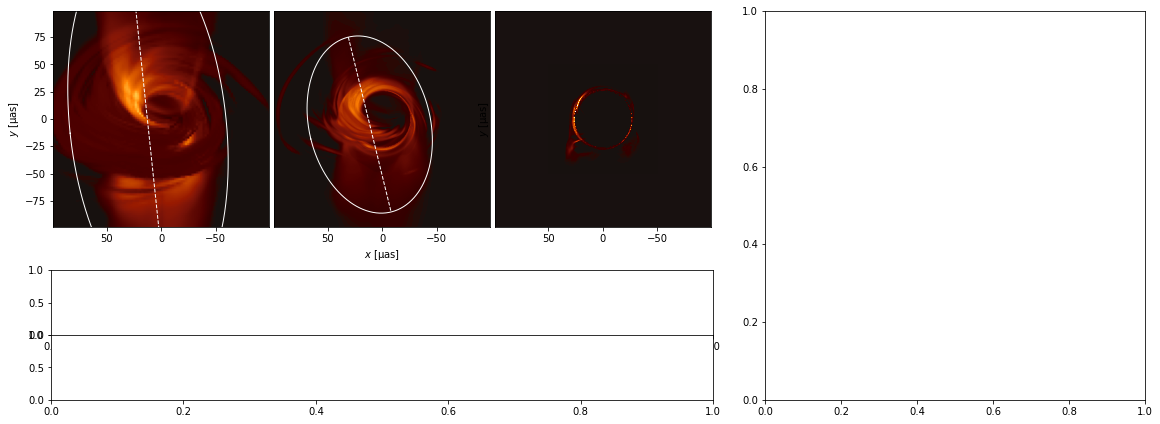

In [12]:
plot_snapshot(0, 'S', 50, 40)

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 991/1000 [15:04<00:08,  1.10it/s]


ValueError: A value in x_new is above the interpolation range.

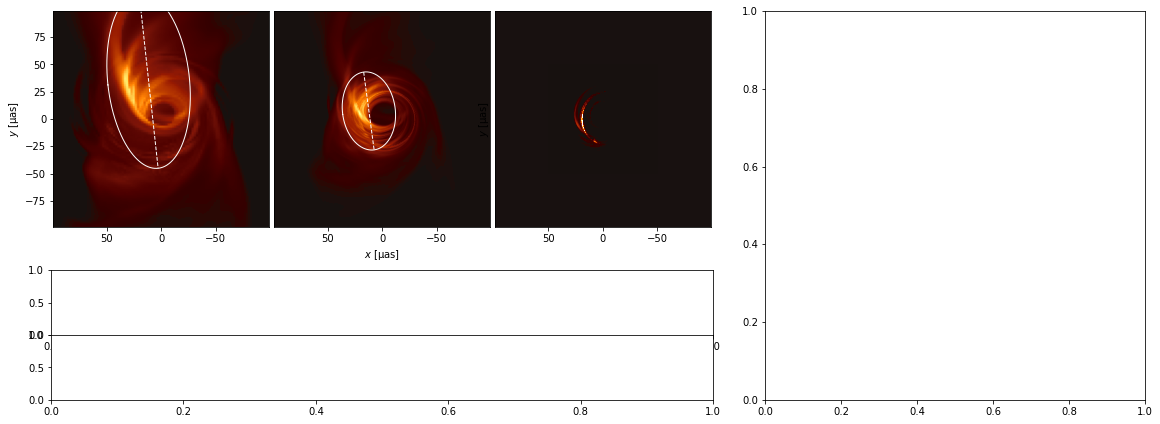

In [7]:
plot_snapshot(0.94, 'S', 30, 40)

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 991/1000 [15:19<00:08,  1.08it/s]


ValueError: A value in x_new is above the interpolation range.

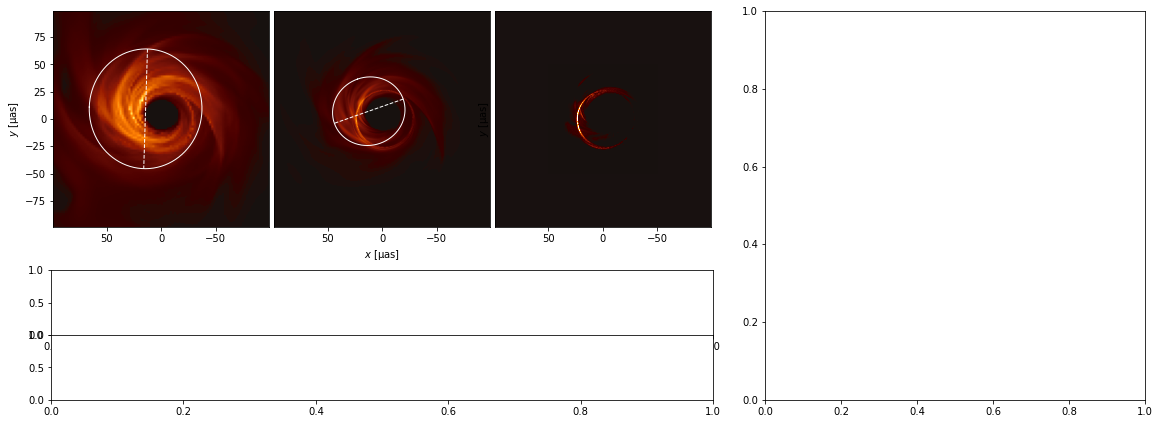

In [8]:
plot_snapshot(0.5, 'M', 30, 40)